Consider the standard regression probelem. We have some observed data $\mathcal{D} = [(\mathbf{x}_1, y_1) \dots (\mathbf{x}_n, y_n)]$ with $\mathbf{x} \in \mathbb{R}^D$ and $y \in \mathbb{R}$. We assume that each observation $y$ can be related to an underlying function $f(\mathbf{x})$ through a Gaussian noise model:

$$y = f(\mathbf{x}) + \mathcal{N}(0, \sigma_n^2)$$

The aim is to find $f(x)$, such that given some new test point $\mathbf{x}_*$, we can accurately estimate the corresponding $y_*$. If we assume that $f(\mathbf{x})$ is linear, then we can simply use the least-squares method to draw a line-of-best-fit and thus arrive at our estimate for $y_*$.

Of course the assumption of a linear model will not normally be valid. To lift this restriction, a simple trick is to project the inputs $\mathbf{x} \in \mathcal{R}^D$ into some higher dimensional space $\mathbf{\phi}(\mathbf{x}) \in \mathcal{R}^M$, where $M > D$, and then apply the above linear model in this space rather than on the inputs themselves. For example, a scalar input $x \in \mathcal{R}$ could be projected into the space of powers of $x$: $\phi({x}) = (1, x, x^2, x^3, \dots x^{M-1})^T$. By applying our linear model now on $\phi(x)$ rather than directly on the inputs $x$, we would implicitly be performing polynomial regression in the input space. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import minimize
np.random.seed(6)

In [2]:
class GPR():
    
    def __init__(self, kernel, optimizer='L-BFGS-B', noise_var=1e-8):
        pass
    
    # 'Public' methods
    def sample_prior(self, X_test, n_samples):
        pass
    def sample_posterior(self, X_test, n_samples):
        pass
    def log_marginal_likelihood(self, theta=None, eval_gradient=None):
        pass
    def optimize(self, theta, X_train, y_train):
        pass
    
    # 'Private' helper methods
    def _build_covariance_matrix(self, X1, X2=None):
        pass
    def _cholesky_factorise(y_cov):
        pass
    def _sample_multivariate_gaussian(y_mean, y_cov):
        pass

In [3]:
# The noise variance gives a measure of how much flexibility the functions have at the position of the observations

By selecting alternative components (a.k.a basis functions) for $\phi(\mathbf{x})$ we can perform regression of more complex functions. But how do we choose the basis functions? In a Gaussian Process Regression (GPR), we need not specify the basis functions explicitly. Rather, we are able to represent $f(\mathbf{x})$ in a more general and flexible, such that the data can have more influence. This is a key advantage of GPR over other types of regression.

A GP simply generalises the definition of a multivariate Gaussian distribution to incorporate infinite dimensions: a GP is a set of random variables, any finite subset of which are multivariate Gaussian distributed. More formally, for any index set $\mathcal{X}$, a GP on $\mathcal{X}$ is a set of random variables $(z_t) = \{z_t: t \in \mathcal{X}\}$ s.t. $\forall n \in \mathcal{N}, \forall x_1, \dots x_n \in \mathcal{X}$, $(z_{x_1} \dots z_{x_n})$ is multivariate Gaussian distributed.  The definition doesn't actually exclude finite index sets, but a G.P defined over a finite index set would simply be a multivariate Gaussian distribution, and would normally be named as such. 

In our case the random variables are the function values $f(\mathbf{x})$ corresponding to all possible input points $\mathbf{x}$. Since we assume any $n$-element subset of these random variables to be $n$-variate Gaussian distributed, our observations $\mathbf{y} = (y_1, \dots, y_n)$ can be imagined as a single point drawn from an $n$-variate Gaussian distribution.

Whilst a multivariate Gaussian distribution is completely specified by a single, finite dimensional, mean vector and covaraince matrix, in a G.P this is not possible, since the finite dimensional distributions (f.d.ds) in terms of which it is defined can have any number of dimensions. Instead we specify the G.P in terms of elementwise mean and covariance functions, $m(\mathbf{x})$ and $k(\mathbf{x}, \mathbf{x}')$, from which the mean vectors and covariance matrices of all possible finite dimensional distributions can be constructed.
$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}'))$.

 Any covariance function is valid so long it constructs a valid covariance matrix i.e. one that is positive semi-definite. The following classes define three valid covariance functions. We house the functions inside classes as they are each associated with hyperparameters that we will want access to later.

In [4]:
class SquaredExponential():
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.theta = [length_scale]
        self.bounds = [length_scale_bounds]
    def __call__(self, x1, x2):
        return np.exp(-1/(2*self.theta[0] ** 2) * np.dot((x1 - x2).T, (x1 - x2)))

class Linear():
    def __init__(self, signal_variance=1.0, signal_variance_bounds=(1e-5, 1e5)):
        self.theta = [signal_variance]
        self.bounds = [signal_variance_bounds]
    def __call__(self, x1, x2):
        return self.theta[0] * np.dot(x1.T, x2)
    
class Periodic():
    def __init__(self, frequency=1.0, frequency_bounds=(1e-5, 1e5)):
        self.theta = [frequency]
        self.bounds = [frequency_bounds]
    def __call__(self, x1, x2):
        return np.exp(-np.sin(self.theta[0] * np.pi * (x1 - x2)) ** 2)

The first method we define for our G.P class is the \__init\__ method. This method is used to associate each G.P instance with a specific kernel function. It also sets a couple of other attributes that we will need later on.

In [5]:
def __init__(self, kernel, optimizer='L-BFGS-B', noise_var=1e-8):
        self.kernel = kernel
        self.noise_var = noise_var
        self.optimizer = optimizer
GPR.__init__ = __init__

The kernel function is used to construct full covariance matrices of all possible f.d.ds. The \_build\_covariance_matrix method performs this task for us.

In [6]:
def _build_covariance_matrix(self, X1, X2=None):
    if X2 is None:
        X2 = X1
    C = np.zeros((X1.shape[0] , X2.shape[0]))
    for i in range(X1.shape[0]):
        for j in range(X2.shape[0]):
            C[i, j] = self.kernel(X1[i], X2[j])
    return C
GPR._build_covariance_matrix = _build_covariance_matrix  # Add to class

To sample functions from our G.P, we first specify the $n_*$ input points at which the sampled functions should be evaluated, and then draw from the corresponding $n_*\text{-variate}$ Gaussian distribution (f.d.d). This corresponds to sampling from the G.P prior, since we have not yet taken into account any observed data, only our prior beleif (via the kernel function) as to which family of functions our target function belongs.

$$\mathbf{f}_* \sim \mathcal{N}\left(\mathbf{0}, K(X_*, X_*)\right)$$



where $X_* \in \mathbb{R}^{n_* \times D}$ holds in its rows each of our $n_*$ input points, and $K(X_*, X_*) = \begin{bmatrix} k(x_1^*, x_1^*) & \ldots & k(x_1^*, x_{n_*}^*) \\
\vdots & \vdots & \vdots \\
k(x_{n_*}^*, x_1^*) & \ldots & k(x_{n_*}^*, x_{n_*}^*) \end{bmatrix}$ is the covariance matrix of the associated f.d.d. 

To implement this sampling operation we proceed as follows. First we build the covariance matrix $K(X_*, X_*)$ for the f.d.d we intend to sample from. This is achieved with the \_build\_covariance_matrix method we defined above. Next we compute the Cholesky decomposition of $K(X_*, X_*)=LL^T$ (possible since $K(X_*, X_*)$ is symmetric positive definite). For this we use the following method:

In [7]:
def _cholesky_factorise(self, y_cov):
    try:
        L = np.linalg.cholesky(y_cov)
    except np.linalg.LinAlgError as e:
        e.args = ("The kernel, %s, is not returning a" 
                  "positive definite matrix. Try increasing"
                  " the noise variance or adding jitter."
                  % self.kernel,) + e.args
        raise
    return L
GPR._cholesky_factorise = _cholesky_factorise

Finally, we use the fact that in order generate Gaussian samples $\mathbf{z} \sim \mathcal{N}(\mathbf{m}, K)$ where K can be decomposed as $K=LL^T$, we can first draw $\mathbf{u} \sim \mathcal{N}(\mathbf{0}, I)$, then compute $\mathbf{z}=\mathbf{m} + L\mathbf{u}$. $z$ has the desired distribution since $\mathbb{E}[\mathbf{z}] = \mathbf{m} + L\mathbb{E}[\mathbf{u}] = \mathbf{m}$ and $\text{cov}[\mathbf{z}] = L\mathbb{E}[\mathbf{u}\mathbf{u}^T]L^T = LL^T = K$. 

In [8]:
def _sample_multivariate_gaussian(self, y_mean, y_cov, n_samples=1):
    y_cov[np.diag_indices_from(y_cov)] += 1e-10  # for numerical stability
    L = self._cholesky_factorise(y_cov)
    u = np.random.randn(y_mean.shape[0], n_samples)
    z = np.dot(L, u) + y_mean[:, np.newaxis]
    return z
GPR._sample_multivariate_gaussian = _sample_multivariate_gaussian

The first line in the above method (adding a small number to the diagonal elements of $K$) is often neccessary to ensure the numerical stability of the cholesky factorisation that follows. The below sample_prior method pulls together all the steps of the sampling process above.

In [9]:
def sample_prior(self, X_test, n_samples=1):
    y_mean = np.zeros(X_test.shape[0])
    y_cov = self._build_covariance_matrix(X_test)
    return self._sample_multivariate_gaussian(y_mean, y_cov, n_samples)
GPR.sample_prior = sample_prior

Let's compare the samples drawn from 3 different G.P priors, one for each of the kernel functions defined above. 

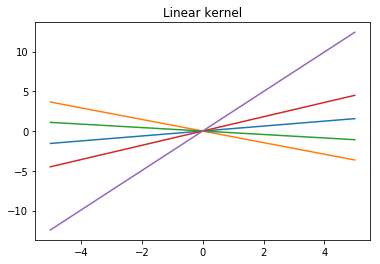

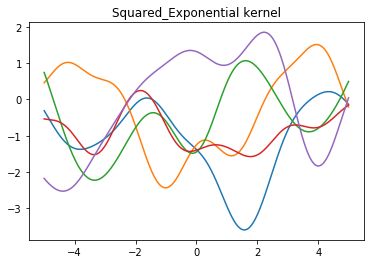

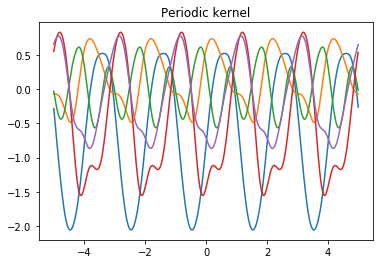

In [10]:
# Define input points at which to evaluate the sampled functions
X_test = np.arange(-5, 5, 0.005)[:, np.newaxis] 

# Experiment with different hyper-parameters for the kernels.
length_scale = 1
signal_variance = 1
frequency = 0.5

gps = {'Linear': GPR(Linear(signal_variance)), 
       'Squared_Exponential': GPR(SquaredExponential(length_scale)),
       'Periodic': GPR(Periodic(frequency))}

for name, gp in gps.items():
    y_samples = gp.sample_prior(X_test, n_samples=5)
    plt.plot(X_test, y_samples)
    plt.title('{} kernel'.format(name))
    plt.show()

By experimenting with the parameters for each of the different kernels, we can can change the characteristics of the sampled functions. The signal variance parameter for the linear kernel controls the variance of the function gradients: small values give a narrow distribution of gradients around zero, and larger values the opposite. The length scale hyperparameter for the Squared Exponential kernel roughly specifies how far apart two input points need to be before their correspoding function values can differ significantly: small values mean less 'co-variance' and so more quickly varying functions, whilst larger values mean more co-variance and so flatter functions. Finally the frequency hyperparameter of the periodic kernel specifies the inverse distance you have to move in input space before the function values repeat themselves: small values mean longer periods and large values the opposite. Note that I could have parameterised each of these functions more to control other aspects of their character e.g. the periodic kernel could also be given a length scale parameter to control the co-variance of function values within each periodic element.

So far we have only drawn functions from the G.P prior. In order to make meaningful predictions, we first need to restrict this prior distribution to contain only those functions that agree with the observed data. In other words we need to form the G.P posterior. 

The f.d.d of the observations $\mathbf{y} \sim \mathbb{R}^n$ defined under the G.P prior is:
$$\mathbf{y} \sim \mathcal{N}\left(\mathbf{0}, K(X, X) + \sigma_n^2I\right)$$

where $X \in \mathbb{R}^{n \times D}$ holds in it's rows each of the $n$ input training points. The additional term $\sigma_n^2I$ is due to the fact that our observations are assumed noisy as described above (we assume that this noise is independent and identically distributed for each observation). 

Using the marginalisation property of multivariate Gaussians, the joint distribution over the observations, $\mathbf{y}$, and test ouputs $\mathbf{f_*}$ according to the G.P prior is
$\begin{bmatrix} \mathbf{y} \\ \mathbf{f}_* \end{bmatrix} = \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} K(X, X) && K(X, X_*) \\ K(X_*, X) && K(X_*, X_*)\end{bmatrix}\right)$.

The G.P posterior is found by conditioning the joint G.P prior distribution on the observations
$$\mathbf{f}_* | X_*, X, \mathbf{y} \sim \mathcal{N}\left(\bar{\mathbf{f}}_*, \text{cov}(\mathbf{f}_*)\right)$$
where $$\mathbf{f}_* = K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}\mathbf{y}$$
$$\text{cov}(\mathbf{f}_*) = K(X_*, X_*) - K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}K(X, X_*)$$

We sample functions from our G.P posterior in exactly the same way as we did from the G.P prior above, but using posterior mean and covariance in place of the prior mean and covariance. Terms involving the matrix inversion $\left[K(X, X) + \sigma_n^2\right]^{-1}$ are handled using the Cholesky factorization of the positive definite matrix $[K(X, X) + \sigma_n^2] = L L^T$. In particular we first pre-compute the quantities $\mathbf{\alpha} = \left[K(X, X) + \sigma_n^2\right]^{-1}\mathbf{y} = L^T \backslash(L \backslash \mathbf{y})$ and $\mathbf{v} = L^T K(X, X)^{-1}K(X, X_*) = L \backslash K(X, X_*)$,
before computing the posterior mean and covariance as
$\bar{\mathbf{f}}_* = K(X, X_*)^T\mathbf{\alpha}$ and $\text{cov}(\mathbf{f}_*) = K(X_*, X_*) - \mathbf{v}^T\mathbf{v}$.

In [11]:
def sample_posterior(self, X_train, y_train, X_test, n_samples=1):
    y_train -= np.mean(y_train, axis=0)
    
    # compute alpha of eqn. 2.25
    K = self._build_covariance_matrix(X_train)
    K[np.diag_indices_from(K)] += self.noise_var
    L = self._cholesky_factorise(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
    
    # Compute posterior mean
    K_trans = self._build_covariance_matrix(X_test, X_train)
    y_mean = K_trans.dot(alpha)  # Line 4 (y_mean = f_star)
    y_mean += np.mean(y_train, axis=0)  

    # Compute posterior covariance
    v = np.linalg.solve(L, K_trans.T)  # L.T * K_inv * K_trans.T
    y_cov = self._build_covariance_matrix(X_test) - np.dot(v.T, v)  # Line 6
    
    return self._sample_multivariate_gaussian(y_mean, y_cov, n_samples), y_mean, y_cov
    
GPR.sample_posterior = sample_posterior

Let's have a look at some samples drawn from the posterior of our Squared Exponential G.P. For observations, we'll use samples from the prior. 

In [12]:
gp = gps['Squared_Exponential']

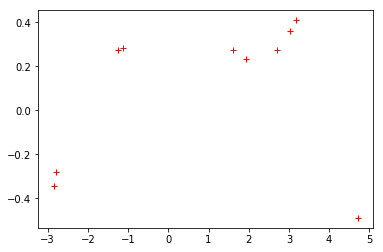

In [13]:
X_train = np.sort(np.random.uniform(-5, 5, 10))[:, np.newaxis]
y_train = gp.sample_prior(X_train)
y_train = y_train[:, 0]  # Only one sample

plt.plot(X_train[:, 0], y_train, 'r+')
plt.show()

In [14]:
y_samples, y_pred_mean, y_pred_covar = gp.sample_posterior(X_train, y_train, X_test, n_samples=10)

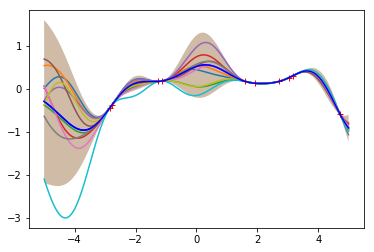

In [15]:
# Plot poterior mean and 95% confidence interval.
pointwise_variances = y_pred_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)
plt.plot(X_test, y_pred_mean, 'b')
plt.fill_between(X_test[:, 0], y_pred_mean - error, y_pred_mean + error, alpha=0.3)

# Plot samples from posterior
plt.plot(X_test, y_samples)

# Also plot our observations for comparison
plt.plot(X_train[:, 0], y_train, 'r+')
plt.plot(X_test, y_pred_mean, 'b')
plt.fill_between(X_test[:, 0], y_pred_mean - error, y_pred_mean + error, alpha=0.3)

plt.show()

As you can see, the posterior samples all pass directly through the observations. This is becuase the noise variance of the G.P was set to it's default value of $10^{-8}$. Increasing the noise variance allows the function values to deviate more from the observations, as can be verified by changing this parameter and re-running the code.

Away from the observations the data lose their influence on the prior and the variance of the function values increases. We know to place less trust in the model's predictions at these locations.

# lml

Of course the reliability of our predictions is dependent on a judicious choice of kernel function. Probably the most widely used is the squared exponential kernel function, which is why we have focussed on it above. But how do we select it's parameters?

By Bayes' theroem, the posterior distribution over the paramters is given by:

$$ p(\mathbf{\theta}|\mathbf{y}, X) = \frac{p(\mathbf{y}|X, \mathbf{\theta}) p(\mathbf{\theta})}{p(\mathbf{y}|X)}$$

The maximum a posteriori (MAP) estimate for $\mathbf{\theta}$ occurs when $p(\mathbf{\theta}|\mathbf{y}, X)$ is greatest. Usually we have little prior knowledge about $\mathbf{\theta}$, and so the prior distribution $p(\mathbf{\theta})$ can be assumed flat. In this case the MAP estimate can be found by maximising the marginal likelihood $p(\mathbf{y}|X, \mathbf{\theta})$, which is the integral of the likelihood times the G.P prior:
$$p(\mathbf{y}|\mathbf{\theta}, X) = \int p(\mathbf{y}|\mathbf{f}, X)p(\mathbf{f}|X)d\mathbf{f}$$
The term marginal refers to marginalization over the function values $\mathbf{f}$. Since the G.P prior and the likelihood are both Gaussian, $p(\mathbf{f}|X) = \mathcal{N}(\mathbf{0}, K)$ and $ p(\mathbf{y}|\mathbf{f}, X) = \mathcal{N}(\mathbf{f}, \sigma^2I) $, the RHS of the above is the integral of a product of Gaussians. This allows us to compute the marginal likelihood in closed form:

$$p(\mathbf{y}|\mathbf{\theta}, X) = \mathcal{N}(\mathbf{0}, K(X, X) + \sigma_n^2I)$$

Maximising this is equivalent to maximising it's log:

$$\text{log}p(\mathbf{y}|X) = -\frac{1}{2}\mathbf{y}^T\left[K(X, X) + \sigma_n^2I\right]^{-1}\mathbf{y} - \frac{1}{2}\text{log}\lvert K(X, X) + \sigma_n^2I \lvert - \frac{n}{2}\text{log}2\pi$$

which can be done by plugging the expression into a multivariate optimizer of your choice, e.g. L-BFGS. 
We already computed $\mathbf{\alpha} = \left[K(X, X) + \sigma_n^2\right]^{-1}\mathbf{y}$ above when dealing with the posterior distribution. The only other tricky term is the one involving the determinant. Here our Cholesky factorisation $[K(X, X) + \sigma_n^2] = L L^T$ comes in handy again:
$$\lvert K(X, X) + \sigma_n^2 \lvert = \lvert L L^T \lvert = \prod_{i=1}^n L_{ii}^2 \quad \text{or} \quad \text{log}\lvert{K(X, X) + \sigma_n^2}\lvert = 2 \sum_i^n \text{log}L_{ii}$$
Let's define the methods to compute and optimize the log marginal likelihood in this way.

In [16]:
def log_marginal_likelihood(self, X_train, y_train, theta, noise_var=None):
    y_train -= np.mean(y_train, axis=0)
    if noise_var is None:
        noise_var = self.noise_var
    
    self.kernel.theta = theta
    
    K = self._build_covariance_matrix(X_train)    
    K[np.diag_indices_from(K)] += noise_var
       
    # Compute L and alpha for this K (theta)
    L = self._cholesky_factorise(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
        
    # Compute log-likelihood (eqn. 2.30)
    log_likelihood = -0.5 * np.dot(y_train.T, alpha)
    log_likelihood -= np.log(np.diag(L)).sum()
    log_likelihood -= K.shape[0] / 2 * np.log(2 * np.pi)
    
    return log_likelihood
GPR.log_marginal_likelihood = log_marginal_likelihood

In [17]:
def optimize(self, X_train, y_train):
    
    def obj_func(theta, X_train, y_train):
            return -self.log_marginal_likelihood(X_train, y_train, theta)
  
    results = minimize(obj_func, 
                       self.kernel.theta, 
                       args=(X_train, y_train), 
                       method=self.optimizer, 
                       jac=None,
                       bounds=self.kernel.bounds)
    self.max_log_marginal_likelihood_value = -results['fun']
    self.kernel.theta_MAP = results['x']
    return results['success']
GPR.optimize = optimize

We can now compute the optimal length scale for our Squared Expoenential G.P.

In [18]:
success = gp.optimize(X_train, y_train)
if success:
    print('MAP estimate of theta is {}. Maximised log marginal liklehihood is {}'.format(gp.kernel.theta_MAP, gp.max_log_marginal_likelihood_value))
else:
    print('Optimization failed. Try setting different initial value of theta.')

MAP estimate of theta is [ 1.08216809]. Maximised log marginal liklehihood is 2.292451806782056


Of course there is no guarantee that we've found the global maximum. It's likely that we've found just one of many local maxima. Still, this MAP estimate of theta is very close to the theta used in the G.P from which the data were generated, which makes sense. We can get get a feel for the positions of any other local maxima that may exist by plotting the contours of the log marginal likelihood as a function of theta. If we allow theta to include the noise variance as well as the length scale, we can check for local maxima along this dimension too. 

In [19]:
# Plot log marginal likelihood w.r.t. different values of theta
length_scales = np.linspace(0.8, 1.4, 100)
noise_variance = np.linspace(1e-12, 1e-2, 100)
X, Y = np.meshgrid(length_scales, noise_variance)

In [20]:
Z = np.array(list(map(lambda x: gp.log_marginal_likelihood(X_train, y_train, theta=[x[0]], noise_var=x[1]), list(zip(X.ravel(), Y.ravel())))))
Z = Z.reshape((X.shape))

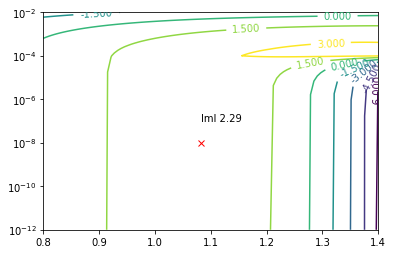

In [22]:
fig, ax = plt.subplots()
#ax.set_xscale('log')
ax.set_yscale('log')
levels = np.arange(-3, 3, 0.25)
CS = ax.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.plot(gp.kernel.theta_MAP[0], gp.noise_var, color='red', marker='x')
plt.annotate('lml {:.2f}'.format(gp.max_log_marginal_likelihood_value), xy=(gp.kernel.theta_MAP[0], gp.noise_var))
plt.show()

The red cross marks the position of our MAP estimate of theta for our G.P with fixed noised variance of $10^{-8}$. We can see that there is another local maximum if we allow the noise to vary, at around $(1.35, 10^{-4})$. In other words, we can fit the data just as well (in fact better) if we increase the length scale but increase the noise i.e. choose a function with a more slowly varying signal but more flexibility around the observations.

Convergence of this optimization process can be improved by passing the gradient of the objective function (the Jacobian) to minimize as well as the objective function itself. This gradient will only exist if the kernel function is differentiable within the bounds of theta, which happens to be true for the Squared Exponential kernel (but may not be for other more exotic kernels). (Rassmussen XX) provides the necessary equations to calculate the gradient of the objective function in this case.

Of course in a full Bayesian treatment we would avoid picking a point estimate like this at all. Instead, at inference time we would integrate over all possible values of $\mathbf{\theta}$ allowed under $p(\mathbf{\theta}|\mathbf{y}, X)$ (Rassmussen see XX Chap 5 once again outlines how to do this).

This post has hopefully helped to de-mistify some of the theory behind Gaussian Processes, explain how they can be applied to regression problems, and demonstrate how they may be implemented. We have only really scratched the surface of what G.Ps are capable of (see Chapter 9 of XXX). In particular they can also be applied to classification tasks and a similar post may follow on this), although becuase a Gaussian likelihood is innapropriate for tasks with discrete outputs, analytical solutions like those we've encountered here do not exist, and approximations must be used. There are also challenges scaling G.Ps to classification tasks with high-dimensional inputs like natural images. Still, the prospect of principled, probabalistic approach to high-dimensional classification tasks is very attractive and would provide a welcome alternative to the point estimates of Deep Learning models.

Let's take a simple example. Take $m(\mathbf{x})=0$ and $k(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i^T\mathbf{x}_j$. $\mathcal{X} \in \mathcal{R}^d$. $k(\mathbf{x}_i, \mathbf{x}_j)$ is a valid covariance function since .

Let's take a simple example. Consider the following GP: $z_\mathbf{x}=\mathbf{x}^T\mathbf{w}$, where $\mathcal{X}=\mathcal{R}^d$, $\mathbf{x} \in \mathcal{X}$, and $\mathbf{w} \in \mathcal{R}^d \sim \mathcal{N}(0, I)$. To show that this defines a valid G.P, we need to show that any finite subset of these random variables is multivariate Gaussian distributed. Consider a subset of $n$ such random variables:
$\mathbf{z} = \mathbf{X}\mathbf{w}$, where $\mathbf{z} = \begin{pmatrix}z_{\mathbf{x}_1} \\ \vdots \\ z_{\mathbf{x}_n} \end{pmatrix}$ and  $\mathbf{X}= \begin{pmatrix}\mathbf{x}_1^T \\ \vdots \\ \mathbf{x}_n^T \end{pmatrix}$. By the affine property of multivariate Gaussians, $\mathbf{z}$ is indeed multivariate ($n$-variate) Gaussian distributed with $\text{E}[\mathbf{z}] = \mathbf{0}$ and $\text{Cov}[\mathbf{z}] = \mathbf{X}\mathbf{X}^T$.

Sampling from this G.P is as easy as sampling from an $n$-variate multivariate Gaussian distribution (where $n$ can be any number $n \in \mathcal{N}$). 

In [ ]:
import numpy as np
X = np.arange(0, 5, 0.005)[:, np.newaxis]

In [ ]:
X.shape

In [ ]:
n = X.shape[0]
y_mean = np.zeros(n)
y_cov = np.dot(X, X.T) + 1e-10*np.eye(X.shape[0])

L = np.linalg.cholesky(y_cov)
u = np.random.randn(n, 50)
z = np.dot(L, u) + y_mean[:, np.newaxis]

In [ ]:
z.shape

### Bayesian Linear Regression -> GP Regression

The standard Bayesian linear regression model with Gaussian noise is:
$$ f(\mathbf{x}) = \mathbf{x}^T \mathbf{w}, \quad y = f(\mathbf{x}) + \epsilon $$
with
$$ \mathbf{w} \sim \mathcal{N}(0, \Sigma_{p}) \quad \text{and} \quad \epsilon \sim \mathcal{N}(0, \sigma^{2}I) $$

Bay
$$x=\sqrt{a^2 + b^2}$$

In [ ]:
from scipy.spatial.distance import pdist, cdist, squareform
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy.optimize import minimize
import warnings

In [ ]:
class GPR():
    def __init__(self, kernel, optimizer, noise_var=1e-10):
        self.kernel = kernel
        self.optimizer = optimizer
        self.noise_var = noise_var
        
    def fit(self, X, y, eval_gradient=True):
        pass
    def predict(self, X):
        pass
    def sample_y(self, X, n_samples):
        pass
    def log_marginal_likelihood(self, theta=None, eval_gradient=None):
        pass

In [ ]:
class RBF():
    
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds
    
    def __call__(self, X1, X2=None, eval_gradient=False):
        if X2 is None:
            # Upper triangular pair-wise distances
            dists = pdist(X1/self.length_scale, 'sqeuclidean')
            K = np.exp(-0.5 * dists)
            K = squareform(K)  # copy upper-triangle to lower-triangle
            np.fill_diagonal(K, 1)
        else:
            if eval_gradient:
                raise ValueError(
                    "Should only be evaluating gradient when X2 is None.")
            dists = cdist(X1/self.length_scale, X2/self.length_scale, 
                          metric='sqeuclidean')
            K = np.exp(-0.5 * dists)
            
        if eval_gradient:
            # Note scipy implementation doesn't divide by self.length_scale but
            # I think this is wrong.
            K_gradient = (K * squareform(dists))[:, :, np.newaxis] / self.length_scale 
            return K, K_gradient
        else:
            return K
    
    def theta(self):
        return np.array([self.length_scale])
    
    def set_theta(self, theta):
        [self.length_scale] = theta
        
    def bounds(self):
        return [self.length_scale_bounds]

In [ ]:
def fit(self, X, y, eval_gradient=True):
    
    # demean our observations and take this mean for GP prior 
    # (realized in computing predictive mean eqn. 2.25)
    self._y_train_mean = np.mean(y, axis=0)
    y = y - self._y_train_mean
    
    self.X_train_ = np.copy(X)
    self.y_train_ = np.copy(y)
    self.kernel_ = copy.copy(self.kernel)  # same as prior kernel 
    # but with parameters to be optimized
    
    def obj_func(theta, eval_gradient):
        if eval_gradient:
            lml, grad = self.log_marginal_likelihood(theta, eval_gradient=True)
            return -lml, -grad
        else:
            return -self.log_marginal_likelihood(theta)
    results = minimize(obj_func, 
                       self.kernel_.theta(), 
                       args=(eval_gradient), 
                       method=self.optimizer, 
                       jac=eval_gradient,
                       bounds=self.kernel_.bounds())
    self.log_marginal_likelihood_value = -results['fun']
    self.kernel_.set_theta(results['x'])
    
    # compute alpha of eqn. 2.25, needed for making predictions and computing lml
    K = self.kernel_(self.X_train_)
    K[np.diag_indices_from(K)] += self.noise_var
    try:
        self.L_ = np.linalg.cholesky(K)
    except np.linalg.LinAlgError as e:
        e.args = ("The kernel, %s, is not returning a" 
                  "positive definite matrix. Try gradually "
                 "increasing the 'alpha' parameter of your "
                    "GaussianProcessRegressor estimator."
                  % self.kernel_,) + e.args
        raise
        
    self.alpha_ = np.linalg.solve(self.L_.T, np.linalg.solve(self.L_, self.y_train_))
    
    return results['success']

GPR.fit = fit

In [ ]:
def predict(self, X):
    """ Returns predictive mean and variance."""
    if not hasattr(self, "X_train_"):  # Unfitted; predict based on GP prior.
        y_mean = np.zeros(X.shape[0])
        y_cov = self.kernel(X)
        return y_mean, y_cov
    else:  # Predict based on GP posterior using kernel with optimized params
        K_trans = self.kernel_(X, self.X_train_)
        y_mean = K_trans.dot(self.alpha_)  # Line 4 (y_mean = f_star)
        y_mean = self._y_train_mean + y_mean  # undo normal.

        v = np.linalg.solve(self.L_, K_trans.T)  # self.L_.T * K_inv * K_trans.T
        y_cov = self.kernel_(X) - np.dot(v.T, v)  # Line 6
        
        # Add jitter to avoid numerical issues
        y_cov[np.diag_indices_from(y_cov)] += 1e-10
      
        return y_mean, y_cov
GPR.predict = predict

In [ ]:
def sample_y(self, X, n_samples=1):
    y_mean, y_cov = self.predict(X)
    
    # z = np.random.multivariate_normal(y_mean, y_cov, n_samples).T  
    try:
        L = np.linalg.cholesky(y_cov)
    except np.linalg.LinAlgError as e:
        e.args = ("The kernel, %s, is not returning a" 
                  "positive definite matrix."
                  % self.kernel,) + e.args
        raise
    u = np.random.randn(X.shape[0], n_samples)
    z = np.dot(L, u) + y_mean[:, np.newaxis]
    return z
GPR.sample_y = sample_y

In [ ]:
def log_marginal_likelihood(self, theta=None, eval_gradient=False, noise_var=None):
    
    if noise_var is None:
        noise_var = self.noise_var
        
    if theta is None:
        assert hasattr(self, "log_marginal_likelihood_value")
        print('Using fitted theta')
        return self.log_marginal_likelihood_value
    
    kernel = copy.deepcopy(self.kernel)
    kernel.set_theta(theta)
    
    if eval_gradient:
        K, K_gradient = kernel(self.X_train_, eval_gradient=True)
    else:
        K = kernel(self.X_train_)
        
    K[np.diag_indices_from(K)] += noise_var
       
    # Compute L and alpha for this K (theta)
    try:
        L = np.linalg.cholesky(K)
    except np.linalg.LinAlgError:
        return (-np.inf, np.zeros_like(theta)) if eval_gradient else -np.inf

    alpha = np.linalg.solve(L.T, np.linalg.solve(L, self.y_train_))
        
    # Compute log-likelihood (eqn. 2.30)
    log_likelihood = -0.5 * np.einsum("i,i", self.y_train_, alpha)
    log_likelihood -= np.log(np.diag(L)).sum()
    log_likelihood -= K.shape[0] / 2 * np.log(2 * np.pi)

    if eval_gradient:
        # Compute lml gradient w.r.t kernel params (eqn. 5.9)
        tmp = np.einsum("i,j->ij", alpha, alpha)
        tmp -= np.linalg.solve(L.T, np.linalg.solve(L, np.eye(K.shape[0])))  # K inverse
        log_likelihood_gradient = 0.5 * np.einsum("ij,ijk->k", tmp, K_gradient)
    
    if eval_gradient:
        return log_likelihood, log_likelihood_gradient
    else:
        return log_likelihood
GPR.log_marginal_likelihood = log_marginal_likelihood

In [ ]:
X = np.sort(np.random.uniform(-5, 5, 10))[:, np.newaxis]
kernel = RBF(length_scale=1)
gp = GPR(kernel, 'L-BFGS-B', noise_var=1e-10)

In [ ]:
# Sample from prior and take as observations
y_sample = gp.sample_y(X)

In [ ]:
y_sample.shape

In [ ]:
%%capture
fig, ax = plt.subplots()

In [ ]:
ax.plot(X, y_sample, 'r+')
ax.set_xlim(-5, 5)
ax.set_ylim(-2.5, 2.5)
fig

In [ ]:
X_test = np.arange(-5, 5, 0.005)[:, np.newaxis]

In [ ]:
gp.fit(X, y_sample[:, 0], True)

In [ ]:
gp.kernel_.theta()

In [ ]:
gp.kernel.theta()

In [ ]:
y_pred_mean, y_pred_covar = gp.predict(X_test)

In [ ]:
ax.plot(X_test, y_pred_mean, 'b')
fig

In [ ]:
# compute 95% confidence interval from pointwise variances and plot
pointwise_variances = y_pred_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)
ax.fill_between(X_test[:, 0], y_pred_mean - error, y_pred_mean + error, alpha=0.3)
fig

In [ ]:
y_pred_sample = gp.sample_y(X_test, n_samples=5)

In [ ]:
for i in range(y_pred_sample.shape[1]):
    ax.plot(X_test, y_pred_sample[:, i])
fig

In [ ]:
gp.log_marginal_likelihood()

In [ ]:
# Plot log marginal likelihood w.r.t. different values of theta
length_scales = np.linspace(0.90, 1.2, 100)
noise_variance = np.linspace(1e-11, 1e-4, 100)
X, Y = np.meshgrid(length_scales, noise_variance)

In [ ]:
X.shape

In [ ]:
Z = np.array(list(map(lambda x: gp.log_marginal_likelihood(theta=[x[0]], noise_var=x[1]), list(zip(X.ravel(), Y.ravel())))))

In [ ]:
Z = Z.reshape((X.shape))

In [ ]:
Z.shape

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
CS = ax.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)